In [2]:
import numpy as np
import pickle as p
import mdtraj as md
import h5py as h
import torch
import os

from matplotlib import pyplot as plt
from glob import glob as g
from pprint import pprint as pp
from tqdm import tqdm
from sklearn.manifold import TSNE

if "analysis" in os.getcwd():
    os.chdir("..")
import cvae
hdf = h.File("./data/cov_cmaps_hdf.h5")
models = g("./models/*/*.pickle")
pp(models)

['./models/300_epochs/pooled35-21-08-25_0003.pickle',
 './models/cov35-21-08-26_1227/pooled35-21-08-26_1227.pickle',
 './models/50_epochs/pooled35-21-08-25_1532.pickle']


In [3]:
model = models[1]
with open(model,"rb") as f:
    nn = p.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn = nn.to(device)
def strip(traj):                                                                                                                                                                      
    for res in traj.top.residues:                                                                                                                                                         
        if res.name == "ALA":                                                                                                                                                             
            zero_idx = res.index                                                                                                                                                                                                                                                                                                                       
            break                                                                                                                                                                         
    res_range = range(zero_idx,zero_idx+595)                                                                                                                                              
    atoms = []                                                                                                                                                                            
    for i in res_range:                                                                                                                                                                   
        for atom in traj.top._residues[i].atoms:                                                                                                                                          
            atoms.append(atom.index)                                                                                                                                                      
    return traj.atom_slice(atoms)

def get_pooled_atom_names(traj):
    def res_name(res):
        return f"{res.name}-{res.resSeq}"
    return [res_name(r) for r in traj.top.residues]

def pool_arr(arr,pool_size=17,cutoff=0.0,preapply=0.8):             
    shape = arr.shape
    if preapply:
        arr = arr < preapply
    try:                    
        assert shape[0] == shape[1]          
        shape = shape[0]                  
    except AssertionError:
        print("Only works for square arrays")
        raise NotImplementedError
    if shape % pool_size != 0:
        print("Please change pool_size\n"
              "None Integer division error")
        raise ArithmeticError
    iters = int(shape/pool_size)
    pooled = np.empty((iters,iters))
    for i in range(iters):
        ilow = i*pool_size
        ihgh = (i+1)*pool_size
        for j in range(iters):
            jlow = j*pool_size
            jhgh = (j+1)*pool_size
            cur_arr = arr[ilow:ihgh,jlow:jhgh]
            pooled[i,j] = 1 if np.average(cur_arr) > cutoff else 0
    return pooled

pdb_ref = "./analysis/ref.pdb"
ref = strip(md.load(pdb_ref))
res_names = get_pooled_atom_names(ref)
res_names[1] = res_names[1].replace("CY1","CYS")
ref.n_residues

595

In [4]:
a = [*hdf["data"].keys()]
a = a[0]
cmap = hdf["data"][a][0]
cmap.shape

(595, 595)

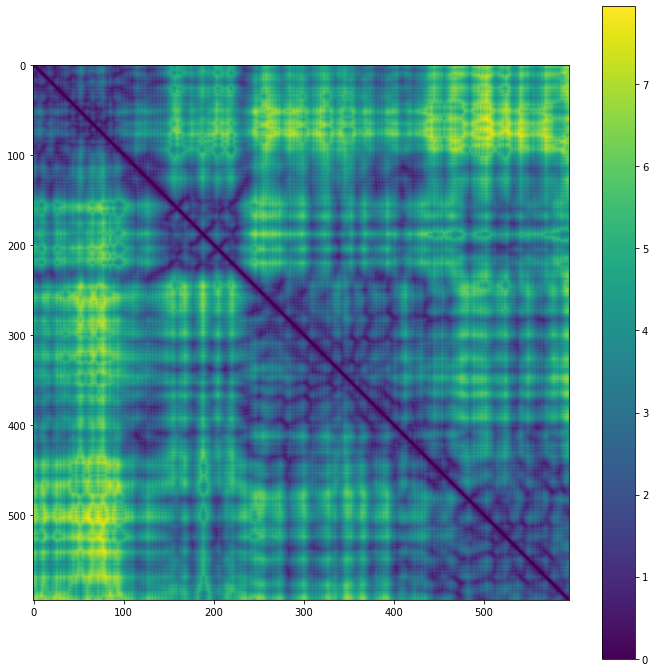

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(cmap)
plt.colorbar()

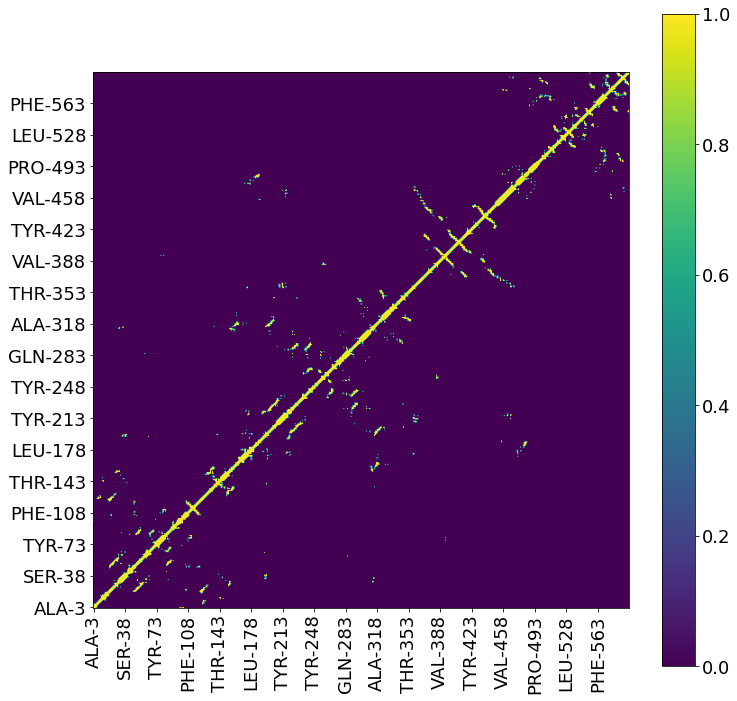

In [6]:
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 18})
plt.imshow(np.flip(cmap < .8,axis=1))
plt.colorbar()
xt = plt.xticks([35*i for i in range(17)],res_names[::35],rotation=90)
yt = plt.yticks([(595-35*i)-1 for i in range(17)],(res_names[::35]))

range(0, 34)

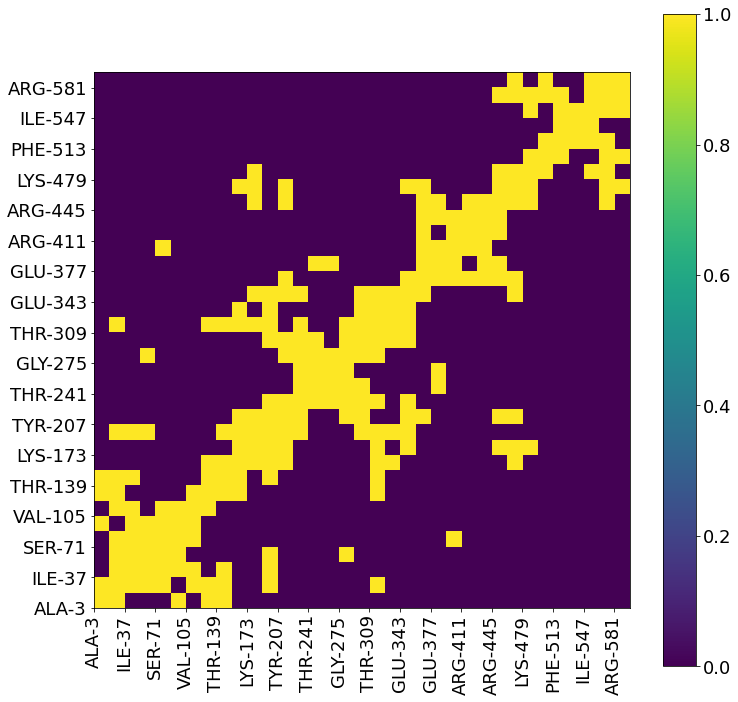

In [7]:
plt.figure(figsize=(12,12))
plt.imshow( np.flip(pool_arr(cmap),axis=1))
plt.colorbar()
xt = plt.xticks([i-0.5 for i in range(35)][::2],res_names[::17][::2],rotation=90)
yt = plt.yticks([(34.5-i) for i in range(35)][::2],(res_names[::17][::2]))
range(*map(int,plt.xlim()),1)

In [8]:
with open("./models/cov35-21-08-26_1227/test_data.p","rb") as f:
    test = p.load(f)
print(test.shape)

torch.Size([11000, 1, 35, 35])


In [9]:
embed = []

device = torch.device("cuda")
for x in tqdm(test):
    with torch.no_grad():
        x = torch.tensor(x).view(1,1,35,35).float().to(device).detach()
        x = np.array(nn(x)[-1].cpu())
        embed.append(x)

  0%|          | 0/11000 [00:00<?, ?it/s]<ipython-input-9-9087616a6175>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).view(1,1,35,35).float().to(device).detach()
100%|██████████| 11000/11000 [00:36<00:00, 304.85it/s]


In [11]:
embed = np.array(embed).reshape(-1,3)
embed.shape

(11000, 3)

In [ ]:
all_data = hdf["pooled_cmaps"][[*hdf["pooled_cmaps"].keys()][0]]
all_data = np.concatenate((all_data[:10000],all_data[-10000:]),axis=0)
embed = []
device = torch.device("cuda")
for x in tqdm(all_data):
    with torch.no_grad():
        x = torch.tensor(x).view(1,1,35,35).float().to(device).detach()
        x = np.array(nn(x)[-1].cpu())
        embed.append(x)
embed = np.array(embed).reshape(-1,3)
tsne_test = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2,n_iter=1000)
trans_test = tsne_test.fit_transform(embed)
plt.figure(figsize=(12,12))
plt.scatter(trans_test[:,0][:10000],trans_test[:,1][:10000],label="APO")
plt.scatter(trans_test[:,0][-10000:],trans_test[:,1][-10000:],label="ATP")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

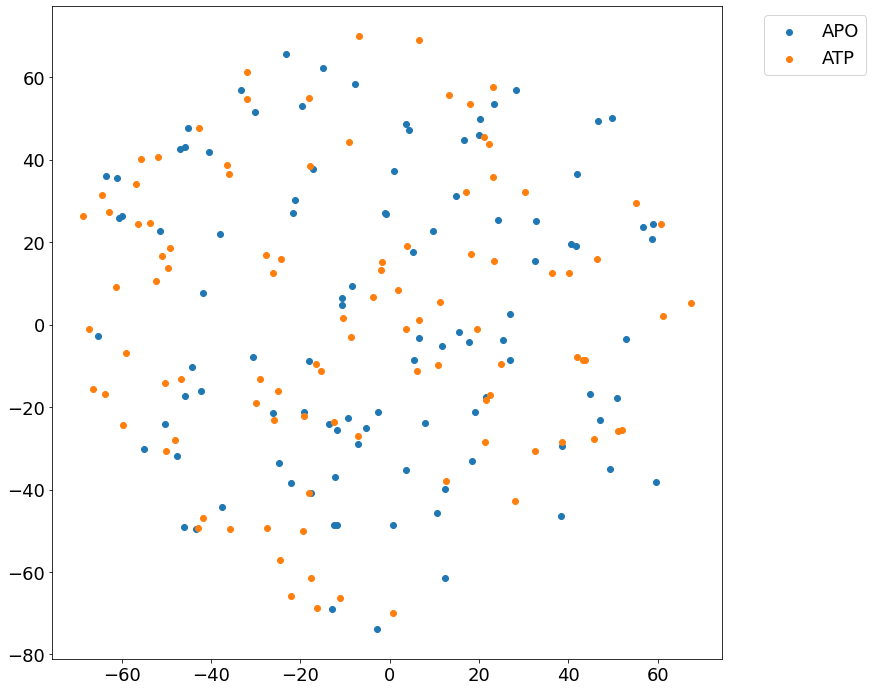

In [34]:
# tsne_test = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2,n_iter=1000)
# trans_test = tsne_test.fit_transform(embed)
plt.figure(figsize=(12,12))
plt.scatter(trans_test[:,0][:100],trans_test[:,1][:100],label="APO")
plt.scatter(trans_test[:,0][-100:],trans_test[:,1][-100:],label="ATP")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

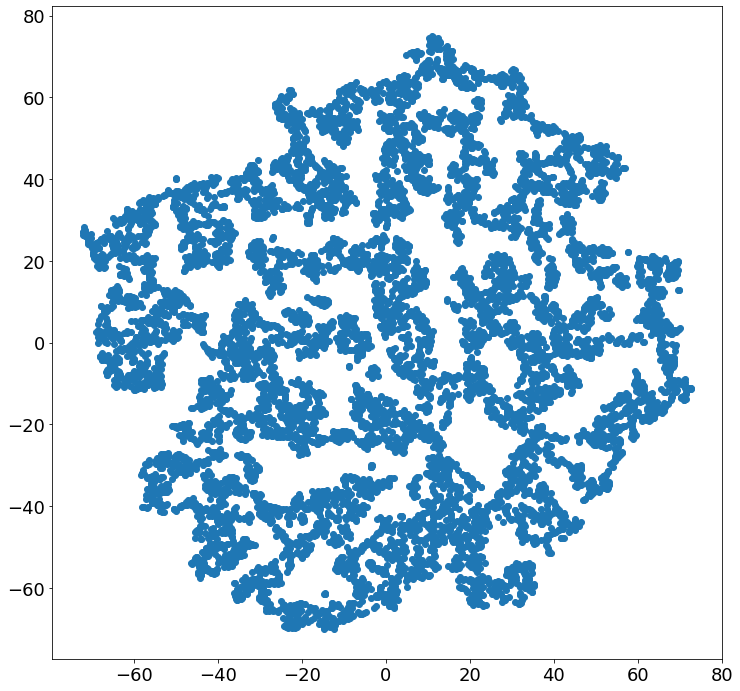

In [13]:
tsne_test = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2,n_iter=5000)
trans_test = tsne_test.fit_transform(np.array(embed).reshape(-1,12))
plt.figure(figsize=(12,12))
plt.scatter(trans_test[:,0],trans_test[:,1])

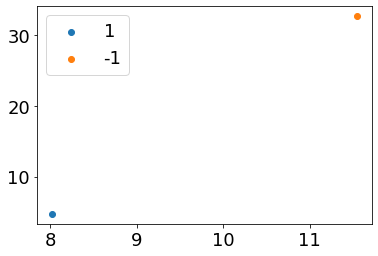

In [32]:
embed = np.array(embed).reshape(-1,12)
# pp(np.mean(embed,axis=0))
embed[0]
embed[-1]
plt.scatter(trans_test[0,0],trans_test[0,1],label="1")
plt.scatter(trans_test[-1,0],trans_test[-1,1],label="-1")
plt.legend()

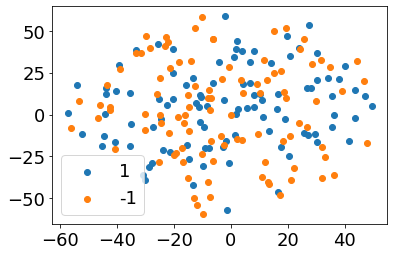

In [33]:
plt.scatter(trans_test[:100,0],trans_test[:100,1],label="1")
plt.scatter(trans_test[-100:,0],trans_test[-100:,1],label="-1")
plt.legend()

In [ ]:
from sklearn.manifold import MDS
mds = MDS(verbose=2)
t_mds = mds.fit_transform(np.array(embed).reshape(-1,12))

In [141]:
keys = [*z_dict.keys()]
pp([(k,len(z_dict[k])) for k in keys])
keys = [keys[0],keys[5]]

[('APO_helicase_140mM-1-cmaps', 10000),
 ('APO_helicase_6JYT_140mM-0-cmaps', 10000),
 ('APO_helicase_minimal_salt-2-cmaps', 15000),
 ('ATP_start-3-cmaps', 30002),
 ('ATP_start-4-cmaps', 30002),
 ('ATP_start-5-cmaps', 10001),
 ('ATP_step3_charmm2namd-10-cmaps', 1000),
 ('ATP_step3_charmm2namd-6-cmaps', 1000),
 ('ATP_step3_charmm2namd-7-cmaps', 1000),
 ('ATP_step3_charmm2namd-8-cmaps', 1000),
 ('ATP_step3_charmm2namd-9-cmaps', 1000)]


In [143]:
data = np.vstack([z_dict[k] for k in keys])
data.shape

(20001, 1, 12)

In [144]:
[len(z_dict[k]) for k in keys]

[10000, 10001]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20001 samples in 0.037s...
[t-SNE] Computed neighbors for 20001 samples in 11.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20001
[t-SNE] Computed conditional probabilities for sample 2000 / 20001
[t-SNE] Computed conditional probabilities for sample 3000 / 20001
[t-SNE] Computed conditional probabilities for sample 4000 / 20001
[t-SNE] Computed conditional probabilities for sample 5000 / 20001
[t-SNE] Computed conditional probabilities for sample 6000 / 20001
[t-SNE] Computed conditional probabilities for sample 7000 / 20001
[t-SNE] Computed conditional probabilities for sample 8000 / 20001
[t-SNE] Computed conditional probabilities for sample 9000 / 20001
[t-SNE] Computed conditional probabilities for sample 10000 / 20001
[t-SNE] Computed conditional probabilities for sample 11000 / 20001
[t-SNE] Computed conditional probabilities for sample 12000 / 20001
[t-SNE] Computed conditional probabilities for s

ValueError: x and y must be the same size

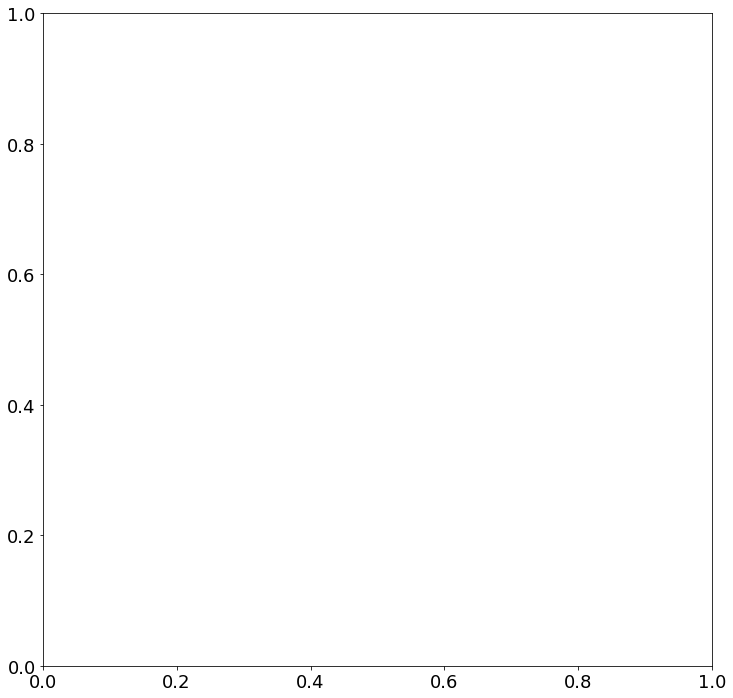

In [146]:
tsne = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=1)
trans = tsne.fit_transform(data.reshape(-1,12))
plt.figure(figsize=(12,12))
prev = 0
plt.scatter(trans[:,0][:10000],trans[:,1][:10000],label=keys[0])
plt.scatter(trans[:,0][10000:20000],trans[:,1][10000:20000],label=keys[1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

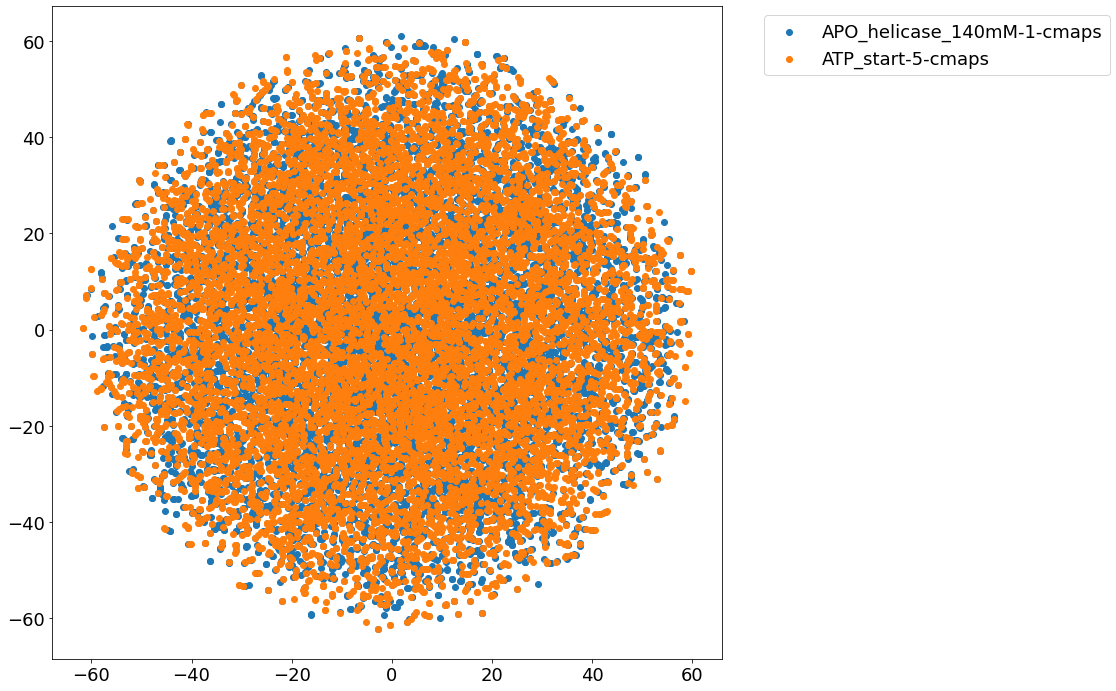

In [147]:
plt.figure(figsize=(12,12))
prev = 0
plt.scatter(trans[:,0][:10000],trans[:,1][:10000],label=keys[0])
plt.scatter(trans[:,0][10000:20000],trans[:,1][10000:20000],label=keys[1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [148]:
hdf

<HDF5 file "cov_cmaps_hdf.h5" (mode r)>

In [156]:
all_data = hdf["virts/all_data"]
hdf
avg_cmap = np.var(all_data[::100],axis=0)

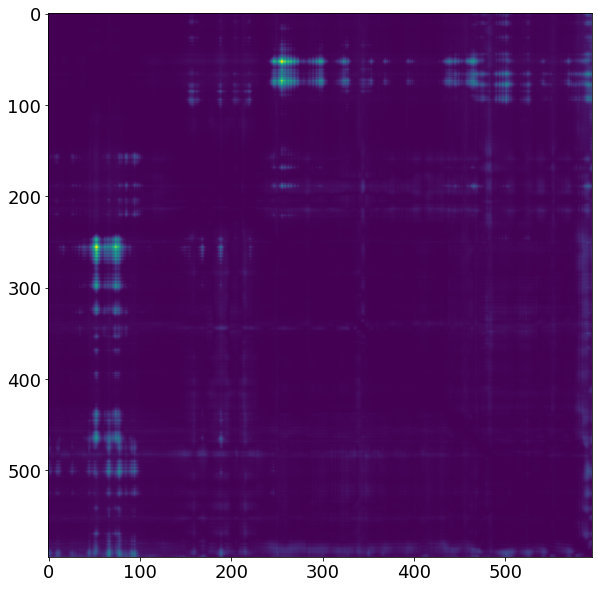

In [157]:
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap)

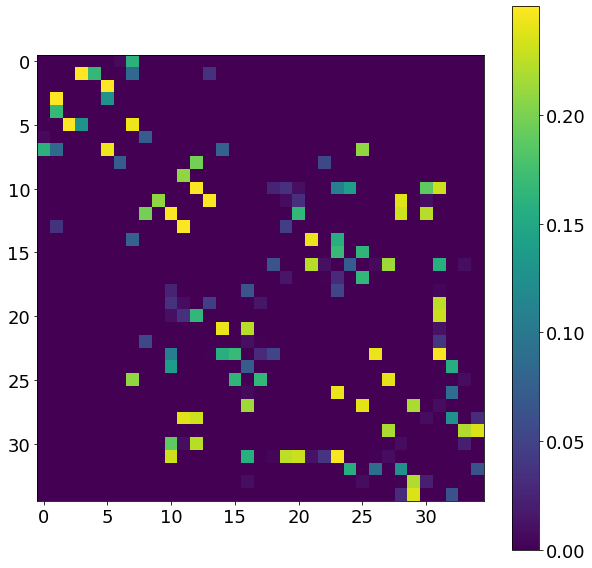

In [166]:
all_data = hdf["pooled_cmaps"][[*hdf["pooled_cmaps"].keys()][0]]
avg_cmap = np.var(all_data[:10000],axis=0)
avg_cmap2 = np.var(all_data[-10000:],axis=0)
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap)
plt.colorbar()

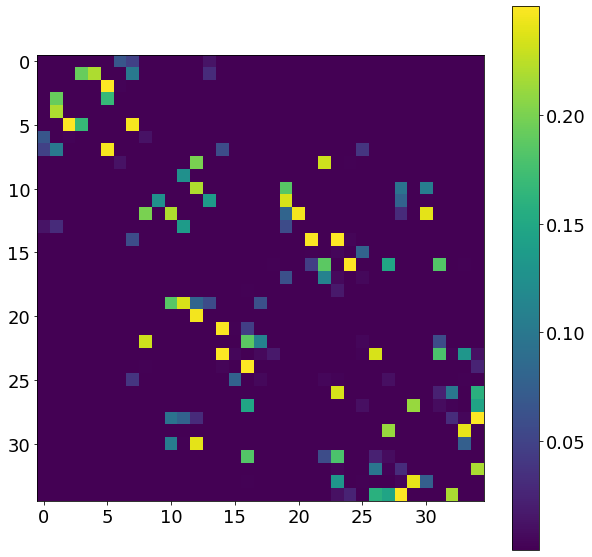

In [167]:
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap2)
plt.colorbar()

In [176]:
nn

cVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(100, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (flat_layer): Flatten(start_dim=1, end_dim=-1)
  (mean): Linear(in_features=169, out_features=12, bias=True)
  (logvar): Linear(in_features=169, out_features=12, bias=True)
  (fc): Linear(in_features=12, out_features=169, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(100, 100, kernel_s

In [16]:
import os
if os.path.isfile("./z_dict.p"):
    with open("z_dict.p","rb") as f:
        z_dict = p.load(f)
else:
    z_dict = {}


with torch.no_grad():
    for dkey,dset in hdf["data"].items():
        if dkey not in z_dict.keys():
            print(f"Working on {dkey}..")
            z_dict.setdefault(dkey,[])
            for x in tqdm(dset):
                x = pool_arr(x)
                x = torch.tensor(x).view(1,1,35,35).float().to(device)
                z = np.array(nn(x)[-1].cpu())
                z_dict[dkey].append(z)
            with open("z_dict.p","wb") as f:
                p.dump(z_dict,f)

Working on APO_helicase_140mM-1-cmaps..


100%|██████████| 10000/10000 [03:31<00:00, 47.26it/s]


Working on APO_helicase_6JYT_140mM-0-cmaps..


100%|██████████| 10000/10000 [03:16<00:00, 50.77it/s]


Working on APO_helicase_minimal_salt-2-cmaps..


100%|██████████| 15000/15000 [04:53<00:00, 51.04it/s]


Working on ATP_start-3-cmaps..


100%|██████████| 30002/30002 [09:48<00:00, 50.94it/s]


Working on ATP_start-4-cmaps..


100%|██████████| 30002/30002 [09:51<00:00, 50.75it/s]


Working on ATP_start-5-cmaps..


100%|██████████| 10001/10001 [03:17<00:00, 50.53it/s]


Working on ATP_step3_charmm2namd-10-cmaps..


100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


Working on ATP_step3_charmm2namd-6-cmaps..


100%|██████████| 1000/1000 [00:20<00:00, 49.50it/s]


Working on ATP_step3_charmm2namd-7-cmaps..


100%|██████████| 1000/1000 [00:20<00:00, 48.36it/s]


Working on ATP_step3_charmm2namd-8-cmaps..


100%|██████████| 1000/1000 [00:19<00:00, 50.68it/s]


Working on ATP_step3_charmm2namd-9-cmaps..


100%|██████████| 1000/1000 [00:19<00:00, 51.54it/s]


In [ ]:
x = [v for v in z_dict.values()]
x = np.vstack(x)
x = x.reshape(-1,10)
tsne = TSNE(perplexity=80.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2)
trans = tsne.fit_transforlm(x)

plt.figure(figsize=(12,12))
prev = 0
for k,v in z_dict.items():
    cur = prev + 1000
    plt.scatter(trans[:,0][prev:cur],trans[:,1][prev:cur],label=k)
    prev += len(v)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 132006 samples in 0.221s...


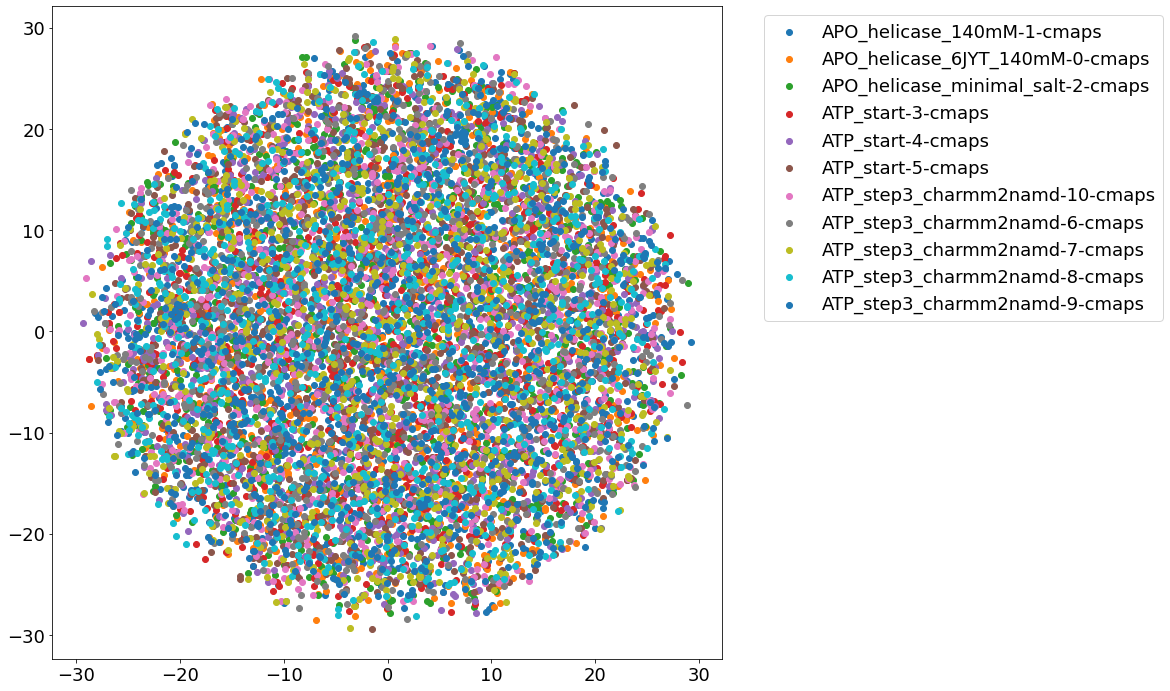

In [108]:
plt.figure(figsize=(12,12))
prev = 0
for k,v in z_dict.items():
    cur = prev + 1000l
    plt.scatter(trans[:,0][prev:cur],trans[:,1][prev:cur],label=k)
    prev += len(v)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

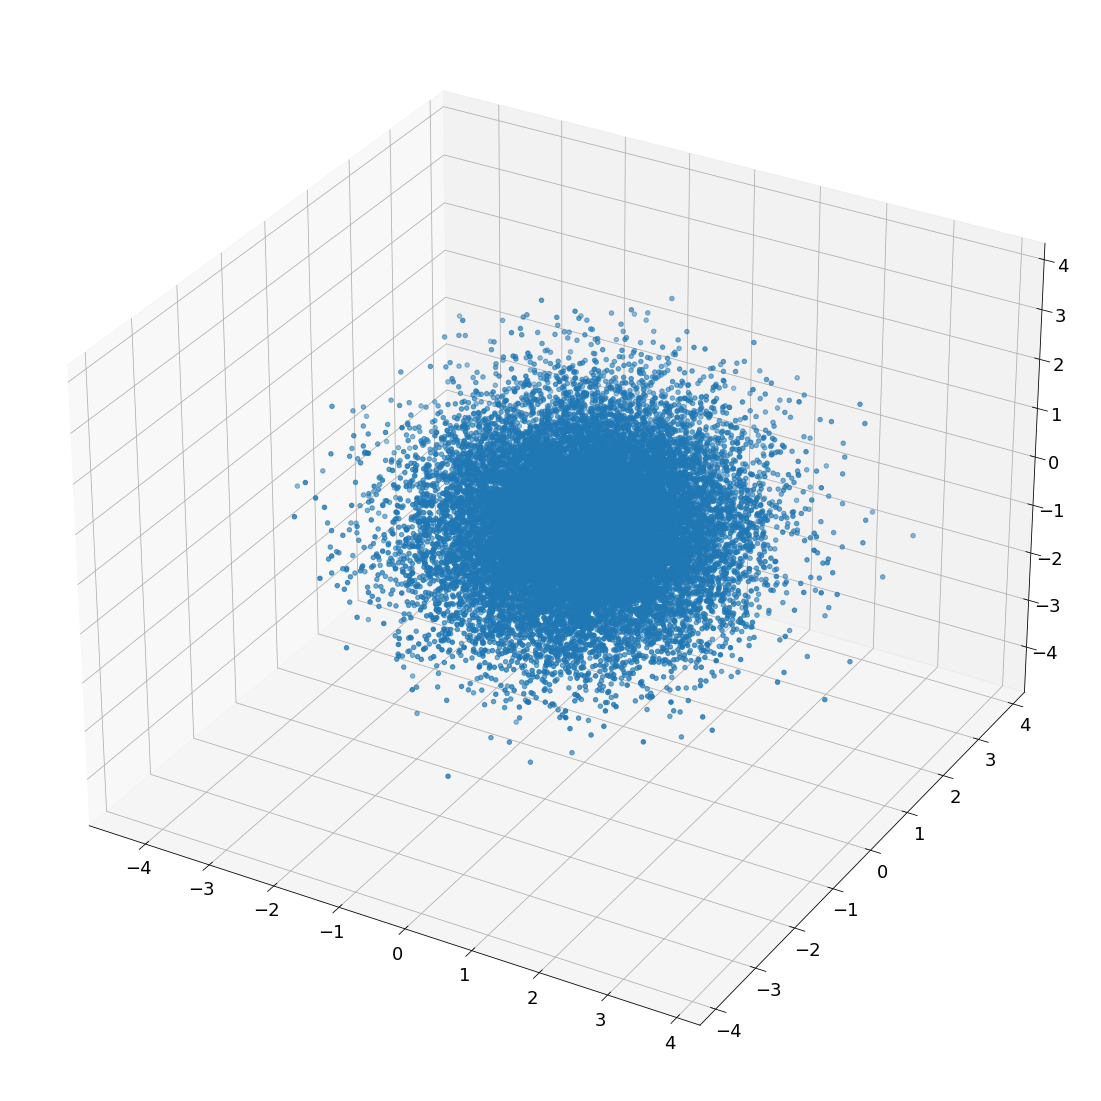

In [33]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter3D(embed[:,0],embed[:,1],embed[:,2])
